# Addiction Simulator

## Setup Virtual Environment
1. make sure python3 is installed on your system.
2. make sure you have a python virtual environment setup: 
python -m pip install --upgrade pip setuptools virtualenv
3. create a python environment: 
python -m venv venv (this creates a virtual environment called venv)
4. if applicable add /venv/ to your .gitignore.
5. activate the virtual environment: 
either \venv\Scripts\activate.bat on windows 
or source venv/bin/activate on mac+linux


## Import Libraries

In [1]:
#basic
from os import system, name
import random
import numpy as np
import math
import matplotlib.pyplot as plt

#pytorch for gpu processing of ML model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable

#rich library for Terminal UI
from rich.jupyter import print
#from rich import print
from rich.prompt import IntPrompt


#hide pytorch warnings (should eventually be resolved)
import warnings
warnings.filterwarnings("ignore")

## Agent's Brain (Deep Q-Learning)

### Neural Network Model

In [2]:
class Network(nn.Module):  
    def __init__(self, input_size, nb_action):
        #ref: https://discuss.pytorch.org/t/super-model-in-init/97426
        #super(Network, self).__init__()
        super().__init__() #pytorch's NN model
        self.input_size = input_size
        self.nb_action = nb_action
        self.fc1 = nn.Linear(input_size, 30)#arbitrarily chose 30 hidden layers
        self.fc2 = nn.Linear(30, nb_action)
    
    #base pytorch NN model runs and we override the
    #forward function with our own relu activation function
    def forward(self, state):
        x = F.relu(self.fc1(state))
        q_values = self.fc2(x)
        return q_values

### Experience Replay Model
This model is used for training our DQN model. It stores the transitions that the agent observes, allowing us to reuse this data later. By sampling from it randomly, the transitions that build up a batch are decorrelated. It has been shown that this greatly stabilizes and improves the DQN training procedure.

In [3]:
class ReplayMemory(): 
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
    
    def push(self, event):
        self.memory.append(event)
        if len(self.memory) > self.capacity:
            del self.memory[0]
    
    def sample(self, batch_size):
        samples = zip(*random.sample(self.memory, batch_size))
        return map(lambda x: Variable(torch.cat(x, 0)), samples)

### DQN Ensemble
Comprised of a neural network model and a memory model. 
* The NN takes in observation of sensor data (brain chemicals) and chooses actions based on the relu activation function. 
* The agent will sample some of the sensor data and store in long term memory to be reused later for training. 
* We also use the Adam Optimisation algorithm. This is an extension to stocastic gradient desent to update weights of the neural network. 

In [4]:
class Dqn():
    def __init__(self, input_size, nb_action, gamma):
        self.gamma = gamma
        self.reward_window = []
        self.model = Network(input_size, nb_action)
        self.memory = ReplayMemory(100000)
        self.optimizer = optim.Adam(self.model.parameters(), lr = 0.001)
        self.last_state = torch.Tensor(input_size).unsqueeze(0)
        self.last_action = 0
        self.last_reward = 0
    
    # select action for x duration
    def select_action(self, state):
        #softmax converts numbers into probabilities
        #Q values are the output of the neural network
        # Temperature value = 100. closer to zero the less sure the NN will be to taking the action
        probs = F.softmax(self.model(Variable(state, volatile = True))*100) # T=100
        #viz q value for each action, (T value by user choice)
        #pie chart 0/1 #seperate action
        action = probs.multinomial(num_samples=1)
        return action.data[0,0]
    
    #to train our AI
    #forward propagation then backproagation
    # get our output, target, compare our output to the target to compute the loss error
    # backproagate loss error into the nn and use stochastic gradient descent we update the weights according to how much they contributed to the loss error
    def learn(self, batch_state, batch_next_state, batch_reward, batch_action):
        outputs = self.model(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
        next_outputs = self.model(batch_next_state).detach().max(1)[0]
        target = self.gamma*next_outputs + batch_reward
        td_loss = F.smooth_l1_loss(outputs, target)
        self.optimizer.zero_grad()
        td_loss.backward(retain_graph = True)
        self.optimizer.step()
    
    #When ai reaches a new state we update everything
    #update action, last action becomes the new action but also the last state becomes the new state and last reward becomes the new state
    # we then get this new transition and update our reward window to track training progress and exploration
    def update(self, reward, new_signal):
        new_state = torch.Tensor(new_signal).float().unsqueeze(0)
        self.memory.push((self.last_state, new_state, torch.LongTensor([int(self.last_action)]), torch.Tensor([self.last_reward])))
        action = self.select_action(new_state)
        if len(self.memory.memory) > 100:
            batch_state, batch_next_state, batch_action, batch_reward = self.memory.sample(100)
            self.learn(batch_state, batch_next_state, batch_reward, batch_action)
        self.last_action = action
        self.last_state = new_state
        self.last_reward = reward
        self.reward_window.append(reward)
        if len(self.reward_window) > 1000:
            del self.reward_window[0]
        return action
    
    def score(self):
        return sum(self.reward_window)/(len(self.reward_window)+1.)
    
    def save(self):
        torch.save({'state_dict': self.model.state_dict(),
                    'optimizer' : self.optimizer.state_dict(),
                   }, 'last_brain.pth')
    def load(self):
        if os.path.isfile('last_brain.pth'):
            print("=> loading checkpoint... ")
            checkpoint = torch.load('last_brain.pth')
            self.model.load_state_dict(checkpoint['state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            print("done !")
        else:
            print("no checkpoint found...")

## Simulation

In [16]:
class Simulation():    
    def __init__(self):
        # Agent Brain - a neural network that represents our Q-function
        self.agent = Dqn(4,8,0.9) # 4 sensors, 8 actions, gama = 0.9
        #Agent's Actions
        self.actions = ['Sleep', 'Binge on Internet', 'Work', 'Exercise', 'Socialise', 'Drink Alcohol', 'Smoke', 'Take Cocaine'] #8 actions
        
        # Mehdi Keramati's definition of an animal ref Mehdi Keramati's Homeostatic RL sim of addiction
        ## fatigue or lever/action cost
        self.fatigue = 1
        #Keramati's outcome, e.g cocaine = 50, representing the dose of self-administered drug,
        self.outcome = [0,10,5,12.5,12.5,10,25,50] #all others were scaled from cocaine as their assumed impact on the brain.
        self.outcomeBuffer = 0

        ## Homeostatic System
        self.initialInState = 0
        self.initialSetpoint = 200
        self.inStateLowerBound = 0
        self.outcomeDegradationRate = 0.007 # e.g dose of cocaine that the animal loses in every time-step
        self.outcomeAbsorptionRatio = 0.12 # e.g proportion of the injected cocaine that affects the brain right after infusion

        ## Allostatic (Stress) System
        self.setpointShiftRate = 0.0018
        self.setpointRecoveryRate = 0.00016
        self.optimalInStateLowerBound = 100
        self.optimalInStateUpperBound = 200

        ## Drive Function
        self.m = 3 # Parameter of the drive function : m-th root
        self.n = 4 # Parameter of the drive function : n-th pawer

        ## Goal-directed system
        self.updateRewardRate = 0.2  # Learning rate for updating the non-homeostatic reward function
        self.updateOutcomeRate = 0.2  # Learning rate for updating the outcome function
        
        #agent's sensors or observation space
        self.last_action = 0 #c(external state /exited)
        self.internal_state = float(self.initialInState) #internal variable that moves homeostatic setpoint
        self.setpoint_S = float(self.initialSetpoint) #homeostatic setpoint

        
        # the mean score curve (sliding window of the rewards) with 
        # respect to time.
        self.scores = []

        #Environment: the agent's grid world is elapsing time from 1 to endpoint
        self.end_day = 364 # day simulation ends
        self.end_hour = 24 # hour simulation ends
        self.total_time = (self.end_day*24+self.end_hour) # total time in hours (size of the world) e.g 1 year or 8760hrs
        self.total_epochs = (self.total_time*3600)/4 #e.g 20 secs is 5 trials or epochs of time or 1 hour = 3600secs/4secs = 900 epochs, 8760hrs is 7,884,000 epochs

        self.current_day = 1 # day agent starts
        self.current_hour = 1 # hour agent starts
        self.elapsed_time = float(0.0) #amount of time that has passed
        self.elapsed_epochs = 0

        # reward agent wants to maximise this will be the homeostatic reward
        self.reward_received = 0


        self.finish = False #trigger to end simulation
        while not self.finish:
            self.finish = self.next_time_interval()# begin simulation and repeat until triggered not to
        if(self.finish):
            #print("saving brain...")
            #brain.save()
            plt.title("Scores [average reward/100 epochs]")
            plt.xlabel("Epochs [4sec intervals]")
            plt.ylabel("Reward")
            plt.plot(self.scores)
            plt.show()

    def next_time_interval(self):
        ## get the time left
        self.elapsed_time = self.elapsed_time + (self.current_day * 23 + self.current_hour) #e.g elapsed time in hours 23hrs + 1hr = 24hrs or 1 day has passed
        time_left = (self.end_day*24 + self.end_hour) - self.elapsed_time #time left in hours, e.g if 24hrs passed then 8,736hrs
        self.elapsed_epochs = (self.elapsed_time*3600)/4 #e.g 1 day = 24hrs = 21,600 epochs
        
        ## agent input state vector, composed of the five brain signals or observations received from being in the environment
        current_state = [self.last_action, self.internal_state, self.setpoint_S, self.elapsed_epochs]
        action_to_take = self.agent.update(self.reward_received, current_state) # playing the action from the ai (dqn class)
        self.scores.append(self.agent.score()) # appending the score (average of the last 100 rewards to the reward window)

        #we can take the agent's NN and call forward to output via softmax q values for each state.
        #suggested_action = self.actions[action_to_take]
        #sa = int(0 if "Sleep" else 1 if suggested_action=="Binge on Video Games" else 2 if suggested_action=="Work" else 3 if suggested_action=="Exercise" else 4 if suggested_action=="Socialise" else 5 if suggested_action=="Drink Alcohol" else 6 if suggested_action=="Smoke" else 7 if suggested_action=="Take Cocaine" else -1)
        
        #give user options
        #self.clear()
        print("** Current Day: [bold dark_violet]" + str(self.current_day) + "[/bold dark_violet], Current Hour: [bold dark_violet]" + str(self.current_hour) + "[/bold dark_violet], Time Left: [bold dark_violet]" + str(time_left) + "[/bold dark_violet] hrs ** \n")
        print("- [bold dark_green]Current State: " + str(self.last_action) + "[/bold dark_green]")
        print("- [bold dark_green]Current Homeostatic Variable: " + str(self.internal_state) + "[/bold dark_green]")
        print("- [bold dark_green]Current Homeostatic Setpoint: " + str(self.setpoint_S) + "[/bold dark_green]")
        print("- [bold dark_green]Time Elapsed: " + str(self.elapsed_time) + "[/bold dark_green]")
        #print("0. [bold dark_violet]Sleep[/bold dark_violet]\n1. [bold dark_violet]Binge on Internet[/bold dark_violet]\n2. [bold dark_violet]Work[/bold dark_violet]\n3. [bold dark_violet]Exercise[/bold dark_violet]\n4. [bold dark_violet]Socialise[/bold dark_violet]\n5. [bold dark_violet]Drink Alcohol[/bold dark_violet]\n6. [bold dark_violet]Smoke[/bold dark_violet]\n")
        
        #action_taken = 0
        #action_taken = IntPrompt.ask("Choose from 1 to 6", default=sa)
        action_taken = action_to_take #automatic
        self.last_action = action_taken #automatic
        #update agent brain chemicals after action taken
        if(action_taken == 0): #Sleep
            #1. update internal sensors or observations of the environment
            #self.current_state = next_state

            ## Update internal state upon consumption  
            interS = self.internal_state + (self.outcome[action_taken] * self.outcomeAbsorptionRatio) - self.outcomeDegradationRate * (self.internal_state - self.inStateLowerBound)
            if interS < self.inStateLowerBound:
                interS = self.inStateLowerBound    
            self.internal_state = interS

            ## Update homeostatic setpoint
            optInS = self.setpoint_S + self.outcome[action_taken]  * self.setpointShiftRate - self.setpointRecoveryRate
            if optInS < self.optimalInStateLowerBound:
                optInS = self.optimalInStateLowerBound
            if optInS > self.optimalInStateUpperBound:
                optInS = self.optimalInStateUpperBound
            self.setpoint_S = optInS

        elif(action_taken != 0 or action_taken != -1): #Binge on Internet, Work, Exercise, Socialise, Drink Alcohol, Smoke
            #1. determine the next state that the agent fell into from taking action
            #n/a
            
            #2. get Non-Homeostatic reward e.g energy cost or fatigue of doing an action
            if action_taken != 0: #if the agent is not sleeping then it is doing something that costs energy
                nonHomeoRew = -self.fatigue
            self.reward_received +=  (1.0 - self.updateRewardRate) * self.reward_received + self.updateRewardRate * nonHomeoRew

            #3. get Homeostatically-regulated Reward of doing action (drive reduction)
            d1 = math.pow(math.fabs(math.pow(self.setpoint_S - self.internal_state, self.n*1.0)),(1.0/self.m))
            d2 = math.pow(math.fabs(math.pow(self.setpoint_S - self.internal_state - self.outcome[action_taken], self.n*1.0)),(1.0/self.m))
            HomeoRew = d1 - d2
            self.reward_received +=  (1.0 - self.updateOutcomeRate) * self.reward_received + self.updateOutcomeRate * HomeoRew
            
            #4. update estimated next state
            # n/a
            
            #5. update internal sensors or observations of the environment
            
            ## Update internal state upon consumption
            self.outcomeBuffer = self.outcomeBuffer + self.outcome[action_taken]   
            interS = self.internal_state + (self.outcomeBuffer * self.outcomeAbsorptionRatio) - self.outcomeDegradationRate * (self.internal_state - self.inStateLowerBound)
            if interS < self.inStateLowerBound:
                interS = self.inStateLowerBound    
            self.internal_state = interS

            ## Update homeostatic setpoint
            optInS = self.setpoint_S + self.outcome[action_taken]  * self.setpointShiftRate - self.setpointRecoveryRate
            if optInS < self.optimalInStateLowerBound:
                optInS = self.optimalInStateLowerBound
            if optInS > self.optimalInStateUpperBound:
                optInS = self.optimalInStateUpperBound
            self.setpoint_S = optInS 

            ## Update outcome buffer
            self.outcomeBuffer = self.outcomeBuffer * (1 - self.outcomeAbsorptionRatio)

        elif(action_taken == -1):#quit
            return True   #end simulation

        #check if this is the last round otherwise continue

        if(time_left <= 0):
            return True   #end simulation
        else:    
            # Updating the last time from the agent to the end time (goal)
            self.current_day += 1  #update to next day interval
            if(self.current_day > self.end_day):
                self.current_day = self.end_day
            self.current_hour += 1 #update to next hour interval
            if(self.current_hour > self.end_hour):
                self.current_hour = 0
            return False

    def clear(self): 
        """
        This function was taken from https://www.geeksforgeeks.org/clear-screen-python/ to
        allow the terminal to be cleared when changing menus or showing the user important
        messages. It checks what operating system is being used and uses the correct 
        clearing command.
        """
        # for windows 
        if name == 'nt': 
            _ = system('cls') 

        # for mac and linux(here, os.name is 'posix')
        else: 
            _ = system('clear')

** Current Day: 1, Current Hour: 1, Time Left: 8736.0 hrs **

- Current State: 0

- Current Homeostatic Variable: 0.0

- Current Homeostatic Setpoint: 200.0

- Time Elapsed: 24.0

** Current Day: 2, Current Hour: 2, Time Left: 8688.0 hrs **

- Current State: tensor(7)

- Current Homeostatic Variable: 6.0

- Current Homeostatic Setpoint: 200

- Time Elapsed: 72.0

** Current Day: 3, Current Hour: 3, Time Left: 8616.0 hrs **

- Current State: tensor(7)

- Current Homeostatic Variable: 17.238

- Current Homeostatic Setpoint: 200

- Time Elapsed: 144.0

** Current Day: 4, Current Hour: 4, Time Left: 8520.0 hrs **

- Current State: tensor(7)

- Current Homeostatic Variable: 33.043734

- Current Homeostatic Setpoint: 200

- Time Elapsed: 240.0

** Current Day: 5, Current Hour: 5, Time Left: 8400.0 hrs **

- Current State: tensor(7)

- Current Homeostatic Variable: 52.827659862

- Current Homeostatic Setpoint: 200

- Time Elapsed: 360.0

** Current Day: 6, Current Hour: 6, Time Left: 8256.0 hrs **

- Current State: tensor(7)

- Current Homeostatic Variable: 76.071270402966

- Current Homeostatic Setpoint: 200

- Time Elapsed: 504.0

** Current Day: 7, Current Hour: 7, Time Left: 8088.0 hrs **

- Current State: tensor(7)

- Current Homeostatic Variable: 102.31856717094523

- Current Homeostatic Setpoint: 200

- Time Elapsed: 672.0

** Current Day: 8, Current Hour: 8, Time Left: 7896.0 hrs **

- Current State: tensor(7)

- Current Homeostatic Variable: 131.1685573822526

- Current Homeostatic Setpoint: 200

- Time Elapsed: 864.0

** Current Day: 9, Current Hour: 9, Time Left: 7680.0 hrs **

- Current State: tensor(7)

- Current Homeostatic Variable: 162.26865124030036

- Current Homeostatic Setpoint: 200

- Time Elapsed: 1080.0

** Current Day: 10, Current Hour: 10, Time Left: 7440.0 hrs **

- Current State: tensor(7)

- Current Homeostatic Variable: 195.30885159017495

- Current Homeostatic Setpoint: 200

- Time Elapsed: 1320.0

** Current Day: 11, Current Hour: 11, Time Left: 7176.0 hrs **

- Current State: tensor(7)

- Current Homeostatic Variable: 230.01664082857363

- Current Homeostatic Setpoint: 200

- Time Elapsed: 1584.0

** Current Day: 12, Current Hour: 12, Time Left: 6888.0 hrs **

- Current State: tensor(7)

- Current Homeostatic Variable: 266.15248139835995

- Current Homeostatic Setpoint: 200

- Time Elapsed: 1872.0

** Current Day: 13, Current Hour: 13, Time Left: 6576.0 hrs **

- Current State: tensor(7)

- Current Homeostatic Variable: 303.5058562374874

- Current Homeostatic Setpoint: 200

- Time Elapsed: 2184.0

** Current Day: 14, Current Hour: 14, Time Left: 6240.0 hrs **

- Current State: tensor(7)

- Current Homeostatic Variable: 341.891784387671

- Current Homeostatic Setpoint: 200

- Time Elapsed: 2520.0

** Current Day: 15, Current Hour: 15, Time Left: 5880.0 hrs **

- Current State: tensor(7)

- Current Homeostatic Variable: 381.14775474354184

- Current Homeostatic Setpoint: 200

- Time Elapsed: 2880.0

** Current Day: 16, Current Hour: 16, Time Left: 5496.0 hrs **

- Current State: tensor(7)

- Current Homeostatic Variable: 421.1310277653314

- Current Homeostatic Setpoint: 200

- Time Elapsed: 3264.0

** Current Day: 17, Current Hour: 17, Time Left: 5088.0 hrs **

- Current State: tensor(7)

- Current Homeostatic Variable: 461.7162609993691

- Current Homeostatic Setpoint: 200

- Time Elapsed: 3672.0

** Current Day: 18, Current Hour: 18, Time Left: 4656.0 hrs **

- Current State: tensor(7)

- Current Homeostatic Variable: 502.7934195493612

- Current Homeostatic Setpoint: 200

- Time Elapsed: 4104.0

** Current Day: 19, Current Hour: 19, Time Left: 4200.0 hrs **

- Current State: tensor(7)

- Current Homeostatic Variable: 544.2659373042648

- Current Homeostatic Setpoint: 200

- Time Elapsed: 4560.0

** Current Day: 20, Current Hour: 20, Time Left: 3720.0 hrs **

- Current State: tensor(7)

- Current Homeostatic Variable: 586.0490988318741

- Current Homeostatic Setpoint: 200

- Time Elapsed: 5040.0

** Current Day: 21, Current Hour: 21, Time Left: 3216.0 hrs **

- Current State: tensor(7)

- Current Homeostatic Variable: 628.0686154581415

- Current Homeostatic Setpoint: 200

- Time Elapsed: 5544.0

** Current Day: 22, Current Hour: 22, Time Left: 2688.0 hrs **

- Current State: tensor(7)

- Current Homeostatic Variable: 670.2593722298542

- Current Homeostatic Setpoint: 200

- Time Elapsed: 6072.0

** Current Day: 23, Current Hour: 23, Time Left: 2136.0 hrs **

- Current State: tensor(7)

- Current Homeostatic Variable: 712.5643252545744

- Current Homeostatic Setpoint: 200

- Time Elapsed: 6624.0

** Current Day: 24, Current Hour: 24, Time Left: 1560.0 hrs **

- Current State: tensor(7)

- Current Homeostatic Variable: 754.9335313724822

- Current Homeostatic Setpoint: 200

- Time Elapsed: 7200.0

** Current Day: 25, Current Hour: 0, Time Left: 985.0 hrs **

- Current State: tensor(7)

- Current Homeostatic Variable: 797.3232942802019

- Current Homeostatic Setpoint: 200

- Time Elapsed: 7775.0

** Current Day: 26, Current Hour: 1, Time Left: 386.0 hrs **

- Current State: tensor(7)

- Current Homeostatic Variable: 839.6954131322883

- Current Homeostatic Setpoint: 200

- Time Elapsed: 8374.0

** Current Day: 27, Current Hour: 2, Time Left: -237.0 hrs **

- Current State: tensor(7)

- Current Homeostatic Variable: 882.0165213229643

- Current Homeostatic Setpoint: 200

- Time Elapsed: 8997.0

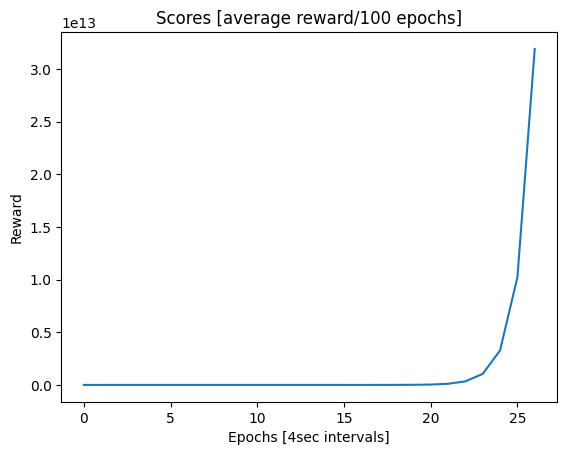

In [17]:
if __name__ == "__main__":
    Simulation() 